# SLEAP Processing Notebook

This Jupyter notebook is designed for processing animal behavior video data using SLEAP, focusing on pose estimation, data aggregation, and analysis.

## Overview

This notebook performs the following key tasks:

1. **Environment Setup**: Imports necessary libraries and modules, sets paths, and configures environment settings.
2. **Data Loading**: Inputs are read from specified directories, which include video data and associated metadata.
3. **Data Processing**:
    - Applies pose estimation algorithms to video data.
    - Aggregates results into structured formats.
    - Filters and cleans the data to prepare for analysis.
4. **Analysis**:
    - Conducts exploratory data analysis (EDA) to understand the behaviors and interactions.
    - Computes statistical metrics and visualizes results using plots.
5. **Output**: Generates and saves outputs, which include processed data frames and visual plots, for further use or inspection.

## Dependencies

- Python 3.x
- Libraries: sys, os, git, glob, pandas, numpy, matplotlib, seaborn, sklearn, utilities, trodes
- External: SLEAP software for pose estimation

## Inputs

- Video files from the directory specified in `video_directory`.
- Behavioral and trial metadata from Excel and pickle files.

## Outputs

- Processed data frames with pose estimation results.
- Statistical analysis results and plots visualizing various aspects of the dataset.

## Functions

This notebook defines several utility functions to aid in data processing and analysis:

- `mask_slices`: Masks parts of a numpy array outside a specified slice.
- `overlay_arrays`: Combines two arrays by overlaying them based on non-NaN values.
- `extract_start_stop_elements`: Retrieves elements from specified start and stop indices in an array.
- `filter_array_by_values`: Filters elements or rows in a numpy array based on value thresholds.

## Usage

To run this notebook:
1. Ensure all dependencies are installed and data files are available in the specified paths.
2. Execute the notebook cells sequentially to perform data loading, processing, analysis, and save the outputs.

Note: Modify the paths and parameters as necessary to fit the data structure and analysis requirements of your project.

# Description of columns

- File metadata and information
```
# Name of SLEAP file
sleap_name
# File path of session directory
session_path
# Name of the recording
recording
# Cohort number
cohort
# Type of experiment
experiment
# File name of video
video_name
# Box number of the recording
box_number
# Name of session directory that the recording is a part of 
session_dir
```

- Subject info
```
current_subject
tracked_subject
all_subjects
subject
agent
```

- Timestamps
```
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
lfp_timestamps
```





- Descriptions of each trial
```
# Origiinal trial labels
condition
# How competitive the trial was
competition_closeness
# Notes on the trial
notes
# The trial label(ie win vs lose)
trial_label
```

- The start and stop frame/timestamps of trials
    ```
    tone_start_frame
    reward_start_frame
    tone_stop_frame
    tone_start_timestamp
    tone_stop_timestamp
    ```

- The frame and timestamp at which port entries were made
```
box_1_port_entry_frames
box_2_port_entry_frames
box_1_port_entry_timestamps
box_2_port_entry_timestamps
```

- LFP Traces
```
mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace
```

- The subjects that are in the video
```
in_video_subjects
```

- list of body parts tracked
```
body_parts
```

- Coordinatres of the corners of the operant chamber
```
box_top_left
box_top_right
reward_port
box_bottom_left
box_bottom_right
```

- SLEAP Output
```
# Coordinates of all the body parts
subject_locations
agent_locations
# Velocity of thorax
subject_thorax_velocity
agent_thorax_velocity
# Distance of thorax to reward port
subject_thorax_to_reward_port
agent_thorax_to_reward_port
```

- The first and last frame of when the subject is in the video
```
start_stop_frame
start_stop_timestamps
```

- Mask used to filter for tones that correspond to trials that are actually in the recording/
```
tone_mask
```

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/social-neuro-modeling'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd

In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
import utilities.helper
import trodes.read_exported

In [11]:
FONTSIZE = 20

In [12]:
font = {'weight' : 'medium',
        'size'   : 10}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [13]:
 COMP_CLOSENESS_DICT = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

In [14]:
BOX_CORNERS = ["box_top_left", "box_top_right", "reward_port", "box_bottom_left", "box_bottom_right"]

In [15]:
ROW_NUMBER = 0

In [16]:
BODY_PART = 'thorax'

In [17]:
X_INDEX = 0
Y_INDEX = 1

In [18]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_2"

In [19]:
TRIAL_LABELS_DF = pd.read_excel("../../data/rce2_finalized_trial_labels.xlsx")

In [20]:
LFP_DF = pd.read_pickle("./proc/rce_pilot_2_01_LFP_and_sleap.pkl")

In [21]:
LFP_DF["video_name"] = LFP_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))
LFP_DF["current_subject"] = LFP_DF["current_subject"].astype(str)

In [22]:
TRIAL_LABELS_DF["current_subject"] = TRIAL_LABELS_DF["current_subject"].astype(str)
TRIAL_LABELS_DF["competition_closeness"] = TRIAL_LABELS_DF["competition_closeness"].map(COMP_CLOSENESS_DICT)

In [23]:
LFP_DF["video_name"].unique()

array(['20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.2',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.3',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2',
       '20230619_115321_standard_comp_

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [24]:
def mask_slices(array_2d, slice_index):
    """
    Masks elements outside a specified slice in a 2D array with NaN.

    Parameters:
    - array_2d (np.ndarray): The input 2D array to mask.
    - slice_index (tuple): A tuple of two integers that specifies the start and end indices 
                           of the slice to retain. The elements outside this slice are set to NaN.

    Returns:
    - np.ndarray: A 2D array with elements outside the specified slice set to NaN.

    Raises:
    - ValueError: If `slice_index` is not a tuple or does not contain exactly two elements.
    - IndexError: If the slice indices are out of the array bounds.
    """
    if not isinstance(slice_index, tuple) or len(slice_index) != 2:
        raise ValueError("slice_index must be a tuple of two integers (start, end).")

    try:
        result = array_2d.copy()
        mask_2d = np.ones(result.shape, dtype=bool)
        mask_2d[slice_index[0]:slice_index[1]] = False

        # Set values outside the defined slice to NaN
        result[mask_2d] = np.nan
        return result

    except IndexError as e:
        warnings.warn(f"Slice index out of bounds: {e}")
        return np.nan
    except Exception as e:
        warnings.warn(f"An error occurred while masking the array: {e}")
        return np.nan


In [25]:
def overlay_arrays(array1, array2):
    """
    Overlays two 2D NumPy arrays of the same shape, preferring non-NaN values from the first array.
    If both arrays have a non-NaN value at the same position, the value from the first array is used.

    Parameters:
    - array1 (np.ndarray): The primary 2D array.
    - array2 (np.ndarray): The secondary 2D array, used only where array1 has NaNs.

    Returns:
    - np.ndarray: A 2D array composed of the overlaid results of array1 and array2.

    Raises:
    - ValueError: If `array1` and `array2` do not have the same shape.
    """
    if array1.shape != array2.shape:
        raise ValueError("Both arrays must have the same shape.")

    # Create a copy of the first array to ensure that no changes are made to the original
    result = np.copy(array1)

    # Find indices where array1 is NaN and array2 is not NaN
    mask = np.isnan(array1) & ~np.isnan(array2)

    # Place non-NaN values from array2 where array1 has NaNs
    result[mask] = array2[mask]

    return result

In [26]:
def extract_start_stop_elements(array, start_index=0, stop_index=-1):
    """
    Extracts elements from an array at specified start and stop indices.
    
    Parameters:
    - array (list or array-like): The array from which elements are to be extracted.
    - start_index (int): The index of the start element. Default is 0.
    - stop_index (int): The index of the stop element. Default is -1, which corresponds to the last element.
    
    Returns:
    - tuple: A tuple containing the elements at the start and stop indices.
    
    If the stop_index is out of the array's range, it defaults to the last element of the array.
    """
    if stop_index >= len(array) or stop_index < 0:
        stop_index = -1  # Ensure the stop_index points to the last element if it's out of range
    return array[start_index], array[stop_index]

In [27]:
def filter_array_by_values(arr, start_value=0, stop_value=1000000):
    """
    Filters elements of a 1D or rows of a 2D numpy array based on specified value range.
    
    Parameters:
    - arr (numpy array): The input numpy array to filter.
    - start_value (numeric): The lower bound for the filtering. Default is 0.
    - stop_value (numeric): The upper bound for the filtering. Default is 1000000.
    
    Returns:
    - numpy array: A numpy array containing only the filtered elements or rows.
    
    Raises:
    - ValueError: If the input array has more than two dimensions.
    """
    result = np.array(arr)
    
    if result.ndim == 1:
        # Apply filter for a 1D array
        mask = (result > start_value) & (result < stop_value)
        return result[mask], mask
    
    elif result.ndim == 2:
        # Apply filter based on the first column for a 2D array
        mask = (result[:, 0] > start_value) & (result[:, 0] < stop_value)
        return result[mask], mask
    
    else:
        raise ValueError("The input array must be either 1D or 2D.")


## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [28]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [29]:
LFP_DF.columns

Index(['cohort', 'session_dir', 'tone_frames', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'session_path', 'recording',
       'current_subject', 'subject', 'all_subjects', 'first_timestamp',
       'last_timestamp', 'video_timestamps', 'tone_timestamps',
       'box_1_port_entry_timestamps', 'box_2_port_entry_timestamps',
       'lfp_timestamps', 'mPFC_lfp_trace', 'MD_lfp_trace', 'LH_lfp_trace',
       'BLA_lfp_trace', 'vHPC_lfp_trace', 'start_frame', 'stop_frame',
       'tracked_subject', 'in_video_subjects', 'box_number', 'sleap_name',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'subject_thorax_velocity', 'agent_thorax_velocity',
       'subject_thorax_to_reward_port', 'agent_thorax_to_reward_port'],
      dtype='object')

In [30]:
LFP_DF = LFP_DF.dropna(subset=["agent_locations"])

In [31]:
TRIAL_LABELS_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness', 'notes',
       'experiment', 'session_dir', 'all_subjects', 'tone_start_timestamp',
       'tone_stop_timestamp', 'trial_label'],
      dtype='object')

# Editing the dataframes

In [32]:
LFP_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port
0,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,..."
3,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.2,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1..."
5,2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,1.1,...,"[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.4,"[[[46.71964110607613, 36.493379374373234], [44...","[[[50.63276479731981, 10.511614189582007], [51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,..."
6,2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,1.4,...,"[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.1,"[[[50.63276479731981, 10.511614189582007], [51...","[[[46.71964110607613, 36.493379374373234], [44...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ..."
9,2,20230614_114041_standard_comp_to_training_D3_s...,"[[855, 1055], [3251, 3450], [5546, 5747], [734...","[[21, 27], [111, 126], [278, 321], [339, 393],...","[[33073, 33085], [33091, 33093], [33094, 33094...",20230614_114041_standard_comp_to_training_D3_s...,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,1.1,1.1,...,"[45.44232917370965, 36.91440422283628]","[30.3

In [33]:
LFP_DF["video_name"].unique()

array(['20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.1',
       '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_and_1-2.1',
       '20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_and_1-4.1',
       '20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_and_1-4.1',
       '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.1',
       '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.4',
 

In [34]:
LFP_DF["tracked_subject"]

0     [1.1, 1.2]
3     [1.1, 1.2]
5     [1.1, 1.4]
6     [1.1, 1.4]
9     [1.1, 1.2]
11    [1.1, 1.2]
13    [1.2, 1.4]
16    [1.2, 1.4]
18    [1.1, 1.2]
19    [1.1, 1.2]
21    [1.1, 1.4]
24    [1.1, 1.4]
26    [1.1, 1.2]
29    [1.1, 1.2]
31    [1.2, 1.4]
32    [1.1, 1.2]
33    [1.1, 1.2]
34    [1.2, 1.4]
35    [1.1, 1.4]
36    [1.1, 1.4]
37    [1.1, 1.2]
38    [1.1, 2.2]
39    [1.1, 2.2]
40    [1.1, 1.2]
41    [1.1, 1.4]
42    [1.1, 2.1]
43    [1.1, 1.4]
44    [1.4, 2.2]
45    [1.2, 1.4]
46    [1.2, 2.2]
47    [1.2, 1.4]
48    [1.4, 2.1]
Name: tracked_subject, dtype: object

In [35]:
LFP_DF["tracked_subject"] = LFP_DF["tracked_subject"].apply(lambda x: "_".join([str(subj) for subj in x]))

In [36]:
# Example with multiple columns being aggregated
GROUPED_TRIAL_LABELS_DF = TRIAL_LABELS_DF.groupby(['video_name', "current_subject"]).agg({col: list for col in [_ for _ in TRIAL_LABELS_DF.columns if _ not in ["video_name", 'current_subject']]  # Aggregating into a list
    # Other columns can be aggregated differently here
}).reset_index()

In [37]:
GROUPED_TRIAL_LABELS_DF.head()

,video_name,current_subject,tracked_subject,box_number,sleap_name,tone_start_frame,reward_start_frame,tone_stop_frame,condition,competition_closeness,notes,experiment,session_dir,all_subjects,tone_start_timestamp,tone_stop_timestamp,trial_label
0,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[standard, standard, standard, standard, stand...",[20230612_112630_standard_comp_to_training_D1_...,"[['1.1', '1.2'], ['1.1', '1.2'], ['1.1', '1.2'...","[1126742, 3526740, 5826740, 7626736, 8726734, ...","[1326741, 3726740, 6026737, 7826735, 8926734, ...","[win, lose, lose, lose, lose, lose, lose, lose..."
1,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[standard, standard, standard, standard, stand...",[20230612_112630_standard_comp_to_training_D1_...,"[['1.1', '1.2'], ['1.1', '1.2'], ['1.1', '1.2'...","[1126742, 3526740, 5826740, 7626736, 8726734, ...","[1326741, 3726740, 6026737, 7826735, 8926734, ...","[lose, win, win, win, win, win, win, win, win,..."
2,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",[20230612_112630_standard_comp_to_training_D1_...,"[37056, 38254, 39352, 40650, 41747, 42746, 437...","[37156, 38354, 39452, 40750, 41847, 42846, 438...","[37256, 38453, 39552, 40849, 41947, 42945, 439...","[rewarded, rewarded, rewarded, rewarded, rewar...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[standard, standard, standard, standard, stand...",[20230612_112630_standard_comp_to_training_D1_...,"[['1.1', '1.2'], ['1.1', '1.2'], ['1.1', '1.2'...","[37126704, 38326703, 39426702, 40726701, 41826...","[37326704, 38526703, 39626701, 40926700, 42026...","[rewarded, rewarded, rewarded, rewarded, rewar..."
3,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[standard, standard, standard, standard, stand...",[20230613_105657_standard_comp_to_training_D2_...,"[['1.1', '1.4'], ['1.1', '1.4'], ['1.1', '1.4'...","[918755, 3318755, 5618754, 7418755, 8518752, 9...","[1118758, 3518757, 5818753, 7618752, 8718757, ...","[lose, win, win, win, win, win, win, win, win,..."
4,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp

## Merging the labels and LFP

In [38]:
TRIALS_AND_LFP_DF = pd.merge(GROUPED_TRIAL_LABELS_DF, LFP_DF, on=["current_subject", "video_name"], how="inner", suffixes=('', '_y'))

In [39]:
for col in TRIALS_AND_LFP_DF:
    print(col)

video_name
current_subject
tracked_subject
box_number
sleap_name
tone_start_frame
reward_start_frame
tone_stop_frame
condition
competition_closeness
notes
experiment
session_dir
all_subjects
tone_start_timestamp
tone_stop_timestamp
trial_label
cohort
session_dir_y
tone_frames
box_1_port_entry_frames
box_2_port_entry_frames
session_path
recording
subject
all_subjects_y
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
lfp_timestamps
mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace
start_frame
stop_frame
tracked_subject_y
in_video_subjects
box_number_y
sleap_name_y
body_parts
box_top_left
box_top_right
reward_port
box_bottom_left
box_bottom_right
agent
subject_locations
agent_locations
subject_thorax_velocity
agent_thorax_velocity
subject_thorax_to_reward_port
agent_thorax_to_reward_port


In [40]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF.columns if "_y" in col], errors="ignore")

In [41]:
TRIALS_AND_LFP_DF["start_stop_frame"] = TRIALS_AND_LFP_DF.apply(lambda x: (x["start_frame"]-1, x["stop_frame"]-1), axis=1)


In [42]:
TRIALS_AND_LFP_DF["start_stop_timestamps"] = TRIALS_AND_LFP_DF.apply(lambda x: extract_start_stop_elements(x["video_timestamps"], x["start_stop_frame"][0], x["start_stop_frame"][1]), axis=1)


- Making all parts of the numpy array that is not part of slice Nans

In [43]:
sleap_columns = ["subject_locations", 
                 "agent_locations", 
                 "subject_thorax_velocity", 
                 "agent_thorax_velocity", 
                 "subject_thorax_to_reward_port", 
                 "agent_thorax_to_reward_port"]

In [44]:
for col in sleap_columns:
    TRIALS_AND_LFP_DF[col] = TRIALS_AND_LFP_DF.apply(lambda x: mask_slices(x[col], x["start_stop_frame"]), axis=1)


- Filtering for frames

In [45]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=["tone_frames", "start_frame", "stop_frame"], errors="ignore")

In [46]:
TRIALS_AND_LFP_DF["tone_mask"] = TRIALS_AND_LFP_DF.apply(lambda x: filter_array_by_values(x["tone_start_frame"], 
                                                                                                   x["start_stop_frame"][0], 
                                                                                                   x["start_stop_frame"][1])[1], axis=1)
                                                                                                   

In [47]:
for column in [col for col in TRIALS_AND_LFP_DF if "frame" in col and col != "start_stop_frame"]:
    TRIALS_AND_LFP_DF[column] = TRIALS_AND_LFP_DF.apply(lambda x: filter_array_by_values(x[column], 
                                                                                                   x["start_stop_frame"][0], 
                                                                                                   x["start_stop_frame"][1])[0], axis=1)
                                                                                                   

In [48]:
TRIALS_AND_LFP_DF["condition"] = TRIALS_AND_LFP_DF.apply(lambda x: np.array(x["condition"])[x["tone_mask"]], axis=1)

In [49]:
TRIALS_AND_LFP_DF["condition"].head()

0    [1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...
1    [1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...
2    [1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...
3    [1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...
4    [1.2, 1.2, 1.1, 1.1, 1.2, 1.1, 1.1, 1.1, 1.1, ...
Name: condition, dtype: object

In [50]:
TRIALS_AND_LFP_DF.head()

,video_name,current_subject,tracked_subject,box_number,sleap_name,tone_start_frame,reward_start_frame,tone_stop_frame,condition,competition_closeness,...,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port,start_stop_frame,start_stop_timestamps,tone_mask
0,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n...",...,1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","(0, 32299)","(1384, 32361438)","[True, True, True, True, True, True, True, Tru..."
1,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n...",...,1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","(0, 32299)","(1384, 32361438)","[True, True, True, True, True, True, True, Tru..."
2,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c...",...,1.4,"[[[46.71964110607613, 36.493379374373234], [44...","[[[50.63276479731981, 10.511614189582007], [51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","(0, 32999)","(1384, 33061302)","[True, True, True, True, True, True, True, Tru..."
3,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c...",...,1.1,"[[[50.63276479731981, 10.511614189582007], [51...","[[[46.71964110607613, 36.493379374373234], [44...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","(0, 32999)","(1384, 33061302)","[True, True, True, True, True, True, True, Tru..."
4,20230614_114041_standard_comp_to_training_D3_s...,1.1,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..

In [51]:
for col in TRIALS_AND_LFP_DF:
    print(col)

video_name
current_subject
tracked_subject
box_number
sleap_name
tone_start_frame
reward_start_frame
tone_stop_frame
condition
competition_closeness
notes
experiment
session_dir
all_subjects
tone_start_timestamp
tone_stop_timestamp
trial_label
cohort
box_1_port_entry_frames
box_2_port_entry_frames
session_path
recording
subject
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
lfp_timestamps
mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace
in_video_subjects
body_parts
box_top_left
box_top_right
reward_port
box_bottom_left
box_bottom_right
agent
subject_locations
agent_locations
subject_thorax_velocity
agent_thorax_velocity
subject_thorax_to_reward_port
agent_thorax_to_reward_port
start_stop_frame
start_stop_timestamps
tone_mask


In [52]:
TRIALS_AND_LFP_DF["video_timestamps"].apply(lambda x: x.shape).head()

0    (68258,)
1    (68258,)
2    (68333,)
3    (68333,)
4    (44209,)
Name: video_timestamps, dtype: object

In [53]:
TRIALS_AND_LFP_DF["subject_thorax_to_reward_port"].apply(lambda x: x.shape).head()

0    (68258,)
1    (68258,)
2    (68333,)
3    (68333,)
4    (44206,)
Name: subject_thorax_to_reward_port, dtype: object

In [54]:
TRIALS_AND_LFP_DF["tone_start_frame"].iloc[ROW_NUMBER]

array([ 1125,  3519,  5815,  7612,  8709,  9708, 11604, 13101, 15198,
       16195, 17793, 19090, 20388, 21385, 22784, 24680, 26276, 27673,
       29870, 31068])

In [55]:
TRIALS_AND_LFP_DF["tone_start_frame"].iloc[1]

array([ 1125,  3519,  5815,  7612,  8709,  9708, 11604, 13101, 15198,
       16195, 17793, 19090, 20388, 21385, 22784, 24680, 26276, 27673,
       29870, 31068])

In [56]:
TRIALS_AND_LFP_DF.iloc[ROW_NUMBER]

video_name                       20230612_112630_standard_comp_to_training_D1_s...
current_subject                                                                1.1
tracked_subject                  [1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...
box_number                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
sleap_name                       [20230612_112630_standard_comp_to_training_D1_...
tone_start_frame                 [1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...
reward_start_frame               [1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...
tone_stop_frame                  [1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...
condition                        [1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...
competition_closeness            [competitive, no_comp, competitive, no_comp, n...
notes                            [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
experiment                       [standard, standard, standard, standard, stand...
sess

In [57]:
TRIALS_AND_LFP_DF.head()

,video_name,current_subject,tracked_subject,box_number,sleap_name,tone_start_frame,reward_start_frame,tone_stop_frame,condition,competition_closeness,...,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port,start_stop_frame,start_stop_timestamps,tone_mask
0,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n...",...,1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","(0, 32299)","(1384, 32361438)","[True, True, True, True, True, True, True, Tru..."
1,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n...",...,1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","(0, 32299)","(1384, 32361438)","[True, True, True, True, True, True, True, Tru..."
2,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c...",...,1.4,"[[[46.71964110607613, 36.493379374373234], [44...","[[[50.63276479731981, 10.511614189582007], [51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","(0, 32999)","(1384, 33061302)","[True, True, True, True, True, True, True, Tru..."
3,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, 1.1_1.4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c...",...,1.1,"[[[50.63276479731981, 10.511614189582007], [51...","[[[46.71964110607613, 36.493379374373234], [44...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","(0, 32999)","(1384, 33061302)","[True, True, True, True, True, True, True, Tru..."
4,20230614_114041_standard_comp_to_training_D3_s...,1.1,"[1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, 1.1_1.2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..

In [58]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF if "band" in col], errors="ignore")

In [59]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF if "phase" in col], errors="ignore")

In [60]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF if "windows" in col], errors="ignore")

In [61]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF if "theta" in col], errors="ignore")

In [62]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF if "gamma" in col], errors="ignore")

In [63]:
TRIALS_AND_LFP_DF = TRIALS_AND_LFP_DF.drop(columns=[col for col in TRIALS_AND_LFP_DF if "frequencies" in col], errors="ignore")

In [64]:
for col in TRIALS_AND_LFP_DF:
    print(col)

video_name
current_subject
tracked_subject
box_number
sleap_name
tone_start_frame
reward_start_frame
tone_stop_frame
condition
competition_closeness
notes
experiment
session_dir
all_subjects
tone_start_timestamp
tone_stop_timestamp
trial_label
cohort
box_1_port_entry_frames
box_2_port_entry_frames
session_path
recording
subject
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
lfp_timestamps
mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace
in_video_subjects
body_parts
box_top_left
box_top_right
reward_port
box_bottom_left
box_bottom_right
agent
subject_locations
agent_locations
subject_thorax_velocity
agent_thorax_velocity
subject_thorax_to_reward_port
agent_thorax_to_reward_port
start_stop_frame
start_stop_timestamps
tone_mask


In [65]:
TRIALS_AND_LFP_DF["tracked_subject"] = TRIALS_AND_LFP_DF["tracked_subject"].apply(lambda x: x[0]) 

In [66]:
TRIALS_AND_LFP_DF["box_number"] = TRIALS_AND_LFP_DF["box_number"].apply(lambda x: x[0]) 

In [67]:
TRIALS_AND_LFP_DF["experiment"] = TRIALS_AND_LFP_DF["experiment"].apply(lambda x: x[0]) 

In [68]:
TRIALS_AND_LFP_DF.iloc[:, :10].head()

,video_name,current_subject,tracked_subject,box_number,sleap_name,tone_start_frame,reward_start_frame,tone_stop_frame,condition,competition_closeness
0,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1_1.2,1,[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n..."
1,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.1_1.2,1,[20230612_112630_standard_comp_to_training_D1_...,"[1125, 3519, 5815, 7612, 8709, 9708, 11604, 13...","[1225, 3619, 5915, 7712, 8809, 9808, 11704, 13...","[1324, 3720, 6014, 7811, 8910, 9907, 11804, 13...","[1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[competitive, no_comp, competitive, no_comp, n..."
2,20230613_105657_standard_comp_to_training_D2_s...,1.1,1.1_1.4,1,[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c..."
3,20230613_105657_standard_comp_to_training_D2_s...,1.4,1.1_1.4,1,[20230613_105657_standard_comp_to_training_D2_...,"[916, 3312, 5608, 7405, 8502, 9501, 11397, 128...","[1016, 3412, 5708, 7505, 8602, 9601, 11497, 12...","[1117, 3513, 5808, 7604, 8703, 9700, 11596, 13...","[1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[no_comp, no_comp, competitive, competitive, c..."
4,20230614_114041_standard_comp_to_training_D3_s...,1.1,1.1_1.2,1,[20230614_114041_standard_comp_to_training_D3_...,"[855, 3251, 5546, 7343, 8441, 9439, 11335, 128...","[955, 3351, 5646, 7443, 8541, 9539, 11435, 129...","[1055, 3450, 5747, 7542, 8640, 9639, 11536, 13...","[1.2, 1.2, 1.1, 1.1, 1.2, 1.1, 1.1, 1.1, 1.1, ...","[competitive, no_comp, no_comp, competitive, c..."


In [69]:
TRIALS_AND_LFP_DF.iloc[:, 10:20].head()

,notes,experiment,session_dir,all_subjects,tone_start_timestamp,tone_stop_timestamp,trial_label,cohort,box_1_port_entry_frames,box_2_port_entry_frames
0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",standard,[20230612_112630_standard_comp_to_training_D1_...,"[['1.1', '1.2'], ['1.1', '1.2'], ['1.1', '1.2'...","[1126742, 3526740, 5826740, 7626736, 8726734, ...","[1326741, 3726740, 6026737, 7826735, 8926734, ...","[win, lose, lose, lose, lose, lose, lose, lose...",2,"[[192, 248], [389, 405], [916, 929], [929, 948...",[]
1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",standard,[20230612_112630_standard_comp_to_training_D1_...,"[['1.1', '1.2'], ['1.1', '1.2'], ['1.1', '1.2'...","[1126742, 3526740, 5826740, 7626736, 8726734, ...","[1326741, 3726740, 6026737, 7826735, 8926734, ...","[lose, win, win, win, win, win, win, win, win,...",2,"[[192, 248], [389, 405], [916, 929], [929, 948...",[]
2,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",standard,[20230613_105657_standard_comp_to_training_D2_...,"[['1.1', '1.4'], ['1.1', '1.4'], ['1.1', '1.4'...","[918755, 3318755, 5618754, 7418755, 8518752, 9...","[1118758, 3518757, 5818753, 7618752, 8718757, ...","[lose, win, win, win, win, win, win, win, win,...",2,"[[49, 67], [70, 79], [360, 366], [460, 469], [...",[]
3,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",standard,[20230613_105657_standard_comp_to_training_D2_...,"[['1.1', '1.4'], ['1.1', '1.4'], ['1.1', '1.4'...","[918755, 3318755, 5618754, 7418755, 8518752, 9...","[1118758, 3518757, 5818753, 7618752, 8718757, ...","[win, lose, lose, lose, lose, lose, lose, lose...",2,"[[49, 67], [70, 79], [360, 366], [460, 469], [...",[]
4,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",standard,[20230614_114041_standard_comp_to_training_D3_...,"[['1.1', '1.2'], ['1.1', '1.2'], ['1.1', '1.2'...","[856955, 3256958, 5556954, 7356953, 8456953, 9...","[1056957, 3456953, 5756952, 7556953, 8656953, ...","[lose, lose, win, win, lose, win, win, win, wi...",2,"[[21, 27], [111, 126], [278, 321], [339, 393],...",[]


In [70]:
TRIALS_AND_LFP_DF.iloc[:, 20:30].head()

,session_path,recording,subject,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,lfp_timestamps
0,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
1,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
2,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,7454593,75876357,"[1384, 1384, 2770, 4156, 4156, 5541, 6927, 831...","[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
3,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,7454593,75876357,"[1384, 1384, 2770, 4156, 4156, 5541, 6927, 831...","[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
4,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,1.1,34373723,102449020,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 8314,...","[[856955, 1056957], [3256958, 3456953], [55569...","[[22157, 27562], [111755, 127157], [278955, 32...","[[33048338, 33059738], [33066538, 33067341], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."


In [71]:
TRIALS_AND_LFP_DF.iloc[:, 30:40].head()

,mPFC_lfp_trace,MD_lfp_trace,LH_lfp_trace,BLA_lfp_trace,vHPC_lfp_trace,in_video_subjects,body_parts,box_top_left,box_top_right,reward_port
0,"[-25, 109, 387, 581, 516, 265, 149, 242, 374, ...","[70, 188, 276, 173, 16, -81, -123, -215, -200,...","[41, 168, 288, 247, 151, 16, -102, -161, -119,...","[23, 46, 98, 135, 85, -84, -245, -236, -107, 4...","[176, 259, 227, -7, -163, -145, -34, -11, -150...","[1.1, 1.2]","[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]"
1,"[-290, -443, -390, -61, -39, -221, -218, -88, ...","[-288, -443, -359, -24, -79, -272, -218, -148,...","[-120, -260, -145, 142, 24, -150, -129, -147, ...","[90, -41, 65, 307, 201, 58, 33, 41, -139, -359...","[1026, 831, 797, 884, 666, 447, 331, 237, -97,...","[1.1, 1.2]","[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]"
2,"[-339, -315, -473, -590, -483, -394, -384, -56...","[-561, -507, -601, -730, -648, -497, -418, -51...","[-462, -453, -620, -747, -615, -473, -498, -68...","[-608, -488, -443, -405, -144, 75, 4, -339, -4...","[-623, -582, -674, -893, -972, -845, -671, -58...","[1.1, 1.4]","[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]"
3,"[-284, -510, -780, -875, -931, -883, -802, -75...","[-44, -194, -365, -387, -400, -445, -496, -519...","[27, -157, -299, -261, -290, -339, -388, -426,...","[333, 279, 0, -345, -552, -781, -888, -669, -3...","[-17, -144, -417, -618, -599, -514, -532, -527...","[1.1, 1.4]","[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]"
4,"[-645, -693, -502, -157, -122, -255, -356, -49...","[-508, -590, -437, -132, -144, -257, -287, -31...","[-456, -533, -343, -19, -61, -229, -339, -381,...","[-333, -359, -263, -167, -341, -572, -659, -70...","[-805, -822, -759, -699, -741, -752, -753, -79...","[1.1, 1.2]","[left_ear, right_ear, nose, tail_base, thorax,...","[29.10707058981441, 11.364487226798616]","[58.883863567261514, 10.806271116252097]","[45.44232917370965, 36.91440422283628]"


In [72]:
TRIALS_AND_LFP_DF.iloc[:, 40:50].head()

,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port,start_stop_frame
0,"[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","(0, 32299)"
1,"[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","(0, 32299)"
2,"[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.4,"[[[46.71964110607613, 36.493379374373234], [44...","[[[50.63276479731981, 10.511614189582007], [51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","(0, 32999)"
3,"[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",1.1,"[[[50.63276479731981, 10.511614189582007], [51...","[[[46.71964110607613, 36.493379374373234], [44...","[4.402, 3.873, 3.361, 2.87, 2.398, 1.946, 1.51...","[4.04, 3.848, 3.658, 3.475, 3.291, 3.113, 2.94...","[28.12, 28.16, 28.22, 28.06, 27.9, 27.9, 27.9,...","[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...","(0, 32999)"
4,"[30.339373669373565, 35.17083382117832]","[59.562580691926456, 34.99992452187238]",1.2,"[[[44.962146067447776, 33.875261125037554], [4...","[[[52.756810221797416, 36.78031943889759], [52...","[8.55, 7.92, 7.3, 6.69, 6.09, 5.496, 4.918, 4....","[31.56, 28.44, 25.4, 22.5, 19.67, 16.97, 14.37...","[5.957, 5.52, 5.055, 4.99, 4.484, 4.047, 4.195...","[10.77, 10.75, 10.76, 10.91, 10.95, 11.234, 11...","(0, 32199)"


In [73]:
TRIALS_AND_LFP_DF.iloc[:, 50:60].head()

,start_stop_timestamps,tone_mask
0,"(1384, 32361438)","[True, True, True, True, True, True, True, Tru..."
1,"(1384, 32361438)","[True, True, True, True, True, True, True, Tru..."
2,"(1384, 33061302)","[True, True, True, True, True, True, True, Tru..."
3,"(1384, 33061302)","[True, True, True, True, True, True, True, Tru..."
4,"(-2, 32260270)","[True, True, True, True, True, True, True, Tru..."


# Demo code

In [74]:
TRIALS_AND_LFP_DF["body_parts"].iloc[ROW_NUMBER]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

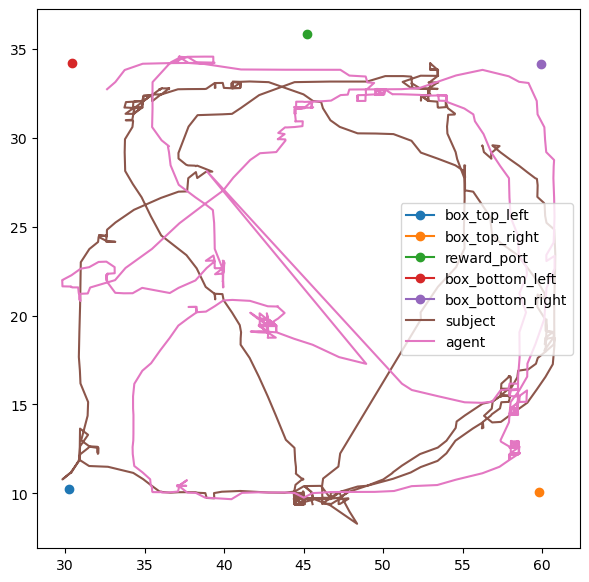

In [75]:
plt.figure(figsize=(7,7))
for corner in BOX_CORNERS:
    corner_coordinates = TRIALS_AND_LFP_DF[corner].iloc[ROW_NUMBER]
    plt.plot(corner_coordinates[X_INDEX], corner_coordinates[Y_INDEX], marker="o", label = corner)
    
subject_locations = TRIALS_AND_LFP_DF["subject_locations"].iloc[ROW_NUMBER]
agent_locations = TRIALS_AND_LFP_DF["agent_locations"].iloc[ROW_NUMBER]

body_index = TRIALS_AND_LFP_DF["body_parts"].iloc[ROW_NUMBER].index(BODY_PART)

plt.plot(subject_locations[:1000,body_index,X_INDEX], subject_locations[:1000,body_index,Y_INDEX], label="subject")
plt.plot(agent_locations[:1000,body_index,X_INDEX], agent_locations[:1000,body_index,Y_INDEX], label="agent")
plt.legend()
plt.show()

In [76]:
TRIALS_AND_LFP_DF["tone_start_frame"].iloc[ROW_NUMBER]


array([ 1125,  3519,  5815,  7612,  8709,  9708, 11604, 13101, 15198,
       16195, 17793, 19090, 20388, 21385, 22784, 24680, 26276, 27673,
       29870, 31068])

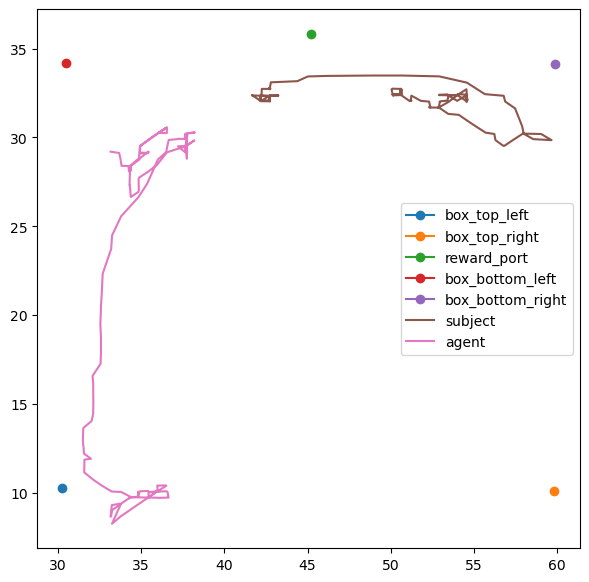

In [77]:
plt.figure(figsize=(7,7))
for corner in BOX_CORNERS:
    corner_coordinates = TRIALS_AND_LFP_DF[corner].iloc[ROW_NUMBER]
    plt.plot(corner_coordinates[X_INDEX], corner_coordinates[Y_INDEX], marker="o", label = corner)
    
subject_locations = TRIALS_AND_LFP_DF["subject_locations"].iloc[ROW_NUMBER]
agent_locations = TRIALS_AND_LFP_DF["agent_locations"].iloc[ROW_NUMBER]

example_tone_start_frame = TRIALS_AND_LFP_DF["tone_start_frame"].iloc[ROW_NUMBER][0]
example_tone_end_frame = TRIALS_AND_LFP_DF["tone_stop_frame"].iloc[ROW_NUMBER][0]


plt.plot(subject_locations[example_tone_start_frame:example_tone_end_frame,body_index,X_INDEX], subject_locations[example_tone_start_frame:example_tone_end_frame,body_index,Y_INDEX], label="subject")
plt.plot(agent_locations[example_tone_start_frame:example_tone_end_frame,body_index,X_INDEX], agent_locations[example_tone_start_frame:example_tone_end_frame,body_index,Y_INDEX], label="agent")
plt.legend()
plt.show()

In [78]:
raise ValueError()

ValueError: 